## Evaluation and Calibration for the MLP Models in `tell`

Blah...

In [1]:
# Start by importing the TELL package and information about your operating system:
import os 
import tell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import DataFrame
from glob import glob
from datetime import datetime


In [2]:
# Identify the current working directory, the "tell_data" directory where the data will is stored, and the image output directory:
current_dir =  os.path.join(os.path.dirname(os.getcwd()))
tell_data_dir = os.path.join(current_dir, r'tell_data')
tell_image_dir = os.path.join(tell_data_dir, r'outputs', r'visualizations')


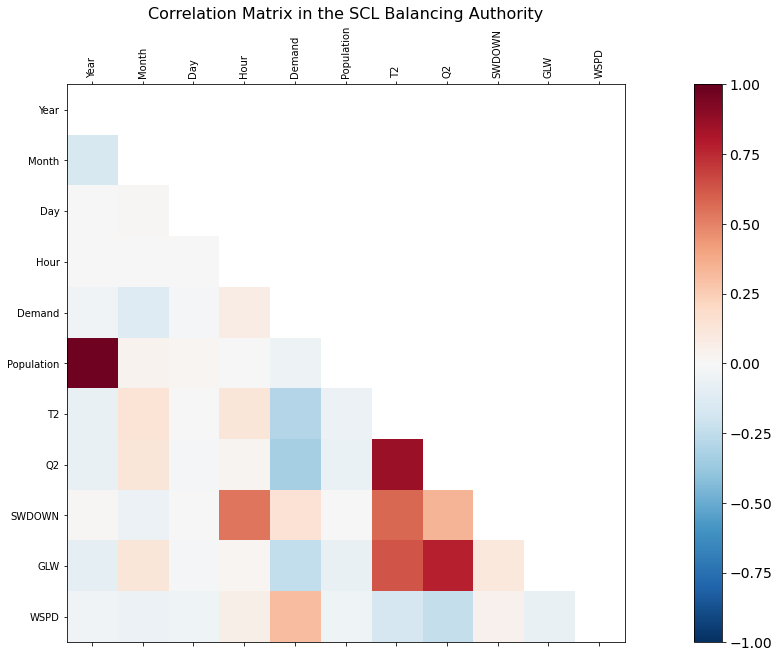

In [19]:
# Plot the correlation between predictive variables in TELL and the historical demand in a given BA. Note that if you set the 'ba_to_plot' variable to "All" the function 
# will compute and plot the average correlation across all BAs:
tell.plot_ba_variable_correlations(ba_to_plot = 'SCL', 
                                   data_input_dir = tell_data_dir,
                                   image_output_dir = tell_image_dir,
                                   image_resolution = 150,
                                   save_images = True)
